In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import re
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob

In [ ]:
dataframe = pd.read_csv("./vaccination_tweets.csv")
dataframe.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


# Nova seção

In [ ]:
from datetime import date
dataframe['today']=date.today()
dataframe['user_created']=pd.to_datetime(dataframe['user_created']).dt.year
dataframe['today']=pd.to_datetime(dataframe['today'])
dataframe['today']=dataframe['today'].dt.year
dataframe['acc_age']= dataframe['today']-dataframe['user_created']
dataframe['date']=pd.to_datetime(dataframe['date'])
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
dataframe = dataframe.join(pd.concat((getattr(dataframe['date'].dt, i).rename(i) for i in L), axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
dataframe.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,today,acc_age,year,month,day,dayofweek,dayofyear,weekofyear,quarter
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,2021,12,2020,12,20,6,355,51,4
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,2021,12,2020,12,13,6,348,50,4
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2021,1,2020,12,12,5,347,50,4
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,2021,13,2020,12,12,5,347,50,4
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2021,1,2020,12,12,5,347,50,4


In [ ]:
dataframe[["first_loc", "second_loc"]] = dataframe["user_location"].str.split(',', expand=True)[[0,1]]
dataframe['second_loc'] = dataframe['second_loc'].str.strip()
state_fix = {
    'Ontario': 'Canada',
    'United Arab Emirates': 'UAE',
    'TX': 'USA',
    'NY': 'USA',
    'FL': 'USA',
    'England': 'UK',
    'Watford': 'UK',
    'GA': 'USA',
    'IL': 'USA',
    'Alberta': 'Canada',
    'WA': 'USA',
    'NC': 'USA',
    'British Columbia': 'Canada',
    'MA': 'USA',
    'ON':'Canada',
    'OH':'USA',
    'MO':'USA',
    'AZ':'USA',
    'NJ':'USA',
    'CA':'USA',
    'DC':'USA',
    'AB':'USA',
    'PA':'USA',
    'SC':'USA',
    'VA':'USA',
    'TN':'USA',
    'New York':'USA',
    'Dubai':'UAE',
    'CO':'USA',
    'BC - Canada': 'CA',
    np.nan: None
  }
dataframe = dataframe.replace({"second_loc": state_fix})
dataframe['second_loc'].value_counts()[:40]

USA                        860
UK                         540
Canada                     183
India                      178
Ireland                     90
UAE                         77
United Kingdom              75
Germany                     61
Belgium                     26
France                      24
South Africa                23
Scotland                    22
Pakistan                    19
Qatar                       17
London                      17
Malaysia                    16
Deutschland                 16
New South Wales             16
MI                          16
Australia                   15
Nederland                   14
Switzerland                 14
a spot in this Universe     14
Spain                       12
California                  11
Italy                       11
Greece                      10
Philippines                 10
Wales                       10
Queensland                   9
Turkey                       9
BC                           9
CT      

In [ ]:
dataframe['acc_class'] = dataframe['user_followers'].apply(
    lambda x:'weak'if x<=100 else ('norm' if 1000>=x>100 else ('strong' if 10000>=x>1000 else 'influencer')))
dataframe.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,today,acc_age,year,month,day,dayofweek,dayofyear,weekofyear,quarter,acc_class,corrected_tweet,subjectivity,polarity,tweet_length,sentiment,first_loc,second_loc
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,2021,12,2020,12,20,6,355,51,4,norm,same folks said maison paste could treat cytok...,0.125000,0.00,short,Neutral,La Crescenta-Montrose,USA
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,2021,12,2020,12,13,6,348,50,4,norm,while the world has been on the wrong side of ...,0.900000,-0.50,long,Negative,San Francisco,USA
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2021,1,2020,12,12,5,347,50,4,weak,russian vaccine is created to last 2-4 years…,0.033333,0.00,short,Neutral,Your Bed,None
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,2021,13,2020,12,12,5,347,50,4,influencer,"facts are immutable, senator, even when you're...",0.550000,-0.05,long,Negative,Vancouver,CA
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2021,1,2020,12,12,5,347,50,4,norm,explain to me again why we need vaccine …,0.000000,0.00,short,Neutral,NaN,None


In [162]:
s_stemmer = SnowballStemmer(language='english')
def pre_process(tweet: str):
    # Remover links
    tweet = re.sub('(https?://\S+)', '', tweet)

    # Remover Hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Remover menções
    tweet = re.sub('@\w+', '', tweet)

    # Remover caracteres sozinhos
    tweet= re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    # Remover caracteres sozinhos no inicio
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet) 

    # Trocar multiplos espaços para um espaço
    tweet = re.sub(r'\s+', ' ', tweet)

    # Remover prefixo b
    tweet = re.sub(r'^b\s+', '', tweet)

    # Tudo para lowercase
    tweet = tweet.lower()

    return tweet

def spell_check(tweet):
    #Corrigir as palavras pela primeira vez
    tweet = str(TextBlob(tweet).correct())

    #Aplicar o radical das palavras
    tweet = s_stemmer.stem(tweet)

    tweet = str(TextBlob(tweet).correct())
    return tweet

In [ ]:

dataframe['corrected_tweet'] = dataframe['text'].apply(pre_process).apply(spell_check)

KeyboardInterrupt: ignored

In [231]:
sentences = [
  'The Brazilian government was incompetent in public and health administration in the face of the pandemic',
  'I lake apples',
  'Congratulations to pfizer for being able to develop this vaccine that will help us in this pandemic',
  'This pandemic is killing my psychologist',
  'I hate the government',
  'what u doing?'
]
classified_sentences = []
for s in sentences:
  tweet = pre_process(s)
  tweet = spell_check(tweet)
  classified_sentences.append((s, TextBlob(tweet).sentiment))

def categorize_polarity(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

for s in classified_sentences:
  print(s[0],'--->',categorize_polarity(s[1].polarity), s[1].polarity, s[1].subjectivity)

The Brazilian government was incompetent in public and health administration in the face of the pandemic ---> Negative -0.175 0.21666666666666667
I lake apples ---> Neutral 0.0 0.0
Congratulations to pfizer for being able to develop this vaccine that will help us in this pandemic ---> Positive 0.5 0.625
This pandemic is killing my psychologist ---> Neutral 0.0 0.0
I hate the government ---> Negative -0.8 0.9
what u doing? ---> Neutral 0.0 0.0


In [170]:


dataframe = pd.read_csv('https://raw.githubusercontent.com/iRitiLopes/projeto_MDados/master/vaccination_tweet_preprocessed.csv?token=AFY42YPC7X5B52O366RL4BTARMP2G')

dataframe['subjectivity'] = dataframe['corrected_tweet'].apply(lambda t: TextBlob(t).sentiment.subjectivity)
dataframe['polarity'] = dataframe['corrected_tweet'].apply(lambda t: TextBlob(t).sentiment.polarity)


In [179]:
dataframe.query('polarity < 0')['corrected_tweet'].iloc[0]

"while the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… "

In [154]:
dataframe['corrected_tweet'].apply(len).describe() # Média 77

dataframe['tweet_length'] = dataframe['corrected_tweet'].apply(lambda x:'short' if len(x)<=77 else 'long')
def categorize_polarity(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

dataframe['sentiment'] = dataframe['polarity'].apply(categorize_polarity)

dataframe.to_csv('./classified_vaccines_pfizer_tweets.csv')

In [140]:
dataframe.head()

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,today,acc_age,year,month,day,dayofweek,dayofyear,weekofyear,quarter,first_loc,second_loc,acc_class,corrected_tweet,subjectivity,polarity,tweet_length,sentiment
0,0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,2021,12,2020,12,20,6,355,51,4,La Crescenta-Montrose,USA,norm,same folks said maison paste could treat cytok...,0.125000,0.00,short,Neutral
1,1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,2021,12,2020,12,13,6,348,50,4,San Francisco,USA,norm,while the world has been on the wrong side of ...,0.900000,-0.50,long,Negative
2,2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2021,1,2020,12,12,5,347,50,4,Your Bed,NaN,weak,russian vaccine is created to last 2-4 years…,0.033333,0.00,short,Neutral
3,3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,2021,13,2020,12,12,5,347,50,4,Vancouver,CA,influencer,"facts are immutable, senator, even when you're...",0.550000,-0.05,long,Negative
4,4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2021,1,2020,12,12,5,347,50,4,NaN,NaN,norm,explain to me again why we need vaccine …,0.000000,0.00,short,Neutral


In [141]:
dfCountries = dataframe.filter(items=['second_loc', 'sentiment'])

In [142]:
dfUSA = dfCountries.query("second_loc == 'USA'")

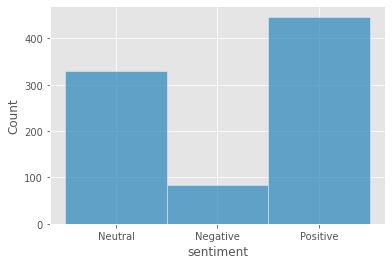

In [143]:
sns.histplot(data = dfUSA, x = "sentiment")

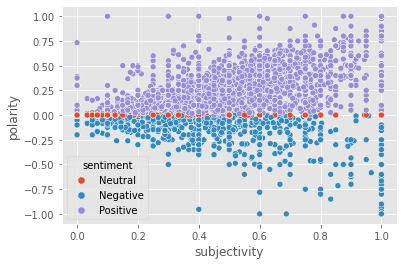

In [144]:
dataframe.groupby('sentiment')['subjectivity'].describe()
sns.scatterplot(x=dataframe['subjectivity'], y=dataframe['polarity'], hue=dataframe['sentiment'])

In [145]:
pd.crosstab(dataframe['acc_class'], dataframe['sentiment'])

sentiment,Negative,Neutral,Positive
acc_class,,,
influencer,73,391,404
norm,333,1390,1477
strong,230,979,910
weak,211,799,852


In [146]:
pd.crosstab(dataframe['acc_age'], dataframe['sentiment'])

sentiment,Negative,Neutral,Positive
acc_age,,,
0,26,63,60
1,88,414,365
2,55,301,298
3,55,193,189
4,47,160,220
5,38,140,162
6,30,172,201
7,51,198,178
8,53,237,223


In [147]:
pd.crosstab(dataframe['acc_age'], dataframe['subjectivity'])
dataframe.groupby(['acc_class', 'sentiment'])['subjectivity'].describe()
top_countries = dataframe.groupby('second_loc').count().sort_values('id', ascending=False)[:5].index

dataframe2 = dataframe[dataframe['second_loc'].isin(top_countries)]
pd.crosstab(dataframe2['second_loc'], dataframe2['sentiment'])

sentiment,Negative,Neutral,Positive
second_loc,,,
Canada,24,67,92
India,21,71,86
Ireland,7,30,53
UK,51,200,289
USA,84,329,447


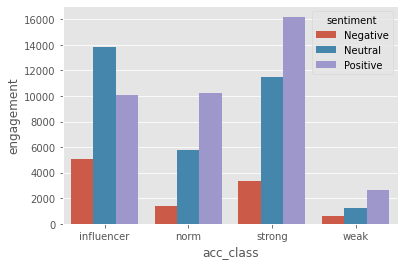

In [148]:
dataframe['engagement'] = dataframe['retweets'] + dataframe['favorites']
total_engagement_by_sentiment = dataframe.groupby(['sentiment', 'acc_class'])['engagement'].sum().reset_index()
sns.barplot(data=total_engagement_by_sentiment, x=total_engagement_by_sentiment.acc_class, y=total_engagement_by_sentiment.engagement, hue='sentiment')

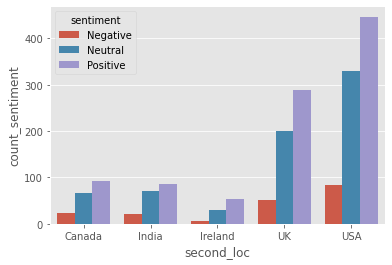

In [149]:
top_countries = dataframe.groupby('second_loc').count().sort_values('id', ascending=False)[:5].index
dataframe2 = dataframe[dataframe['second_loc'].isin(top_countries)]
dataframe2 = dataframe2.groupby(['second_loc', 'sentiment']).count()['id'].rename('count_sentiment').reset_index()
sns.barplot(data=dataframe2, x='second_loc', y='count_sentiment', hue='sentiment')

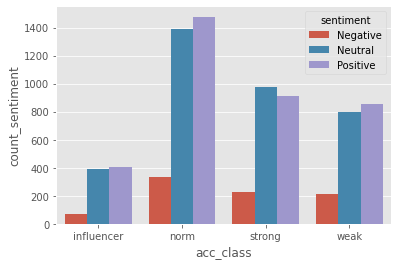

In [153]:
count_sentiment_by_accclass = dataframe.groupby(['acc_class', 'sentiment']).count()['id'].rename('count_sentiment').reset_index()
sns.barplot(data=count_sentiment_by_accclass, x='acc_class', y='count_sentiment', hue='sentiment')